In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models.ldamodel import LdaModel
from data_preprocessing import *
from model import *

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, Dropout, Flatten, Bidirectional, Conv1D, concatenate, SpatialDropout1D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping

print(tf.__version__)

2.2.0


In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
x_train = training_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [5]:
y_train, y_val = label_encoder(y_train, y_val)

In [6]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [7]:
pad_len=100
padding_type='post'
truncating_type='post'

In [8]:
corpus = []
for text in x_train:
    corpus.append(text)
print(len(corpus))
for text in x_val:
    corpus.append(text)
print(len(corpus))

41997
45777


In [9]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(corpus, x_train, x_val)

In [10]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [ ]:
dump(tokenizer, "../tokenizers/DL-raw-tokenizer-100.pk1")

In [11]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [12]:
vocab = tokenizer.word_index
len(vocab.keys())

55100

# Domain Specific Fasttext Embeddings

In [13]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.raw.complete.ft.skipgram.new.d300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

54625
Total time taken:  4.7293841830000005


(55101, 300)

In [14]:
input_dim1 = embedding_matrix1.shape[0]
embedding_dim1 = 300
input_len = pad_len
print("Input dimension 1: ", input_dim1)
print("Embedding dimensions 1: ", embedding_dim1)
print("Input sentence dimensions 1: ", input_len)

Input dimension 1:  55101
Embedding dimensions 1:  300
Input sentence dimensions 1:  100


# LDA Topic-document matrix

In [15]:
LDA_model = LdaModel.load("/home/eastwind/word-embeddings/LDA/Normal/TechDofication.LDA.normal.raw.t12")

In [16]:
start = process_time()
X_train_LDA =prepare_LDA_input(training_data.text.values.tolist(), LDA_model)
X_val_LDA =prepare_LDA_input(val_data.text.values.tolist(), LDA_model)
end = process_time()
print("Total time taken: ", end-start)
print(X_train_LDA.shape)
print(X_val_LDA.shape)

Total time taken:  19.224071924
(41997, 12)
(3780, 12)


In [17]:
input_len2 = X_train_LDA.shape[1]
print("Input dimension 2: ", input_len2)

Input dimension 2:  12


# Multi-channel BiLSTM-CNN Architecture with Attention

In [18]:
class TopicAttention(Layer):
    
    def __init__(self, **kwargs):
        super(TopicAttention, self).__init__(**kwargs)
        
        
    def build(self, attention_input):
        # Attention model weights
        self.W = self.add_weight(shape=(attention_input[-1], 1),
                                  initializer='normal',
                                  trainable=True,
                                  name='attention_weights')
        # Attention model bias
        self.b = self.add_weight(shape=(1, 1),
                                 initializer='normal',
                                 trainable=True,
                                 name='attention_bias')
        super(TopicAttention, self).build(attention_input)
        
        
    def call(self, attention_input):
        et = K.squeeze(K.tanh(K.dot(attention_input, self.W) + self.b), axis=-1)
        at = K.expand_dims(K.softmax(et), axis=-1)
        at = attention_input * at
        #attention_output = K.sum(at, axis=1)
        return at
    
    
    def compute_output_shape(self, attention_input):
        return (attention_input[0], attention_input[-1])
    
    
    def get_config(self):
        return super(TopicAttention, self).get_config()

In [19]:
class AttentionLayer(Layer):
    
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
        
    def build(self, attention_input):
        super(AttentionLayer, self).build(attention_input)
        lstm_shape, cnn_shape = attention_input
        # Attention Weights for LSTM
        self.W_in = self.add_weight(shape=(lstm_shape[-1], 1),
                                    initializer='glorot_normal',
                                    trainable=True,
                                    name='input_attention_weights')
        
        # Attention Weights for CNN
        self.W_context = self.add_weight(shape=(cnn_shape[-1], 1),
                                         initializer='glorot_normal',
                                         trainable=True,
                                         name='context_attention_weights')
                                      
        # Attention Bias
        self.b = self.add_weight(shape=(lstm_shape[1], 1),
                                 initializer='glorot_normal',
                                 trainable=True,
                                 name='attention_bias')
        
        
        
    def call(self, attention_input):
        lstm_output, cnn_output = attention_input
        et = K.squeeze(K.tanh(K.dot(lstm_output, self.W_in) + 
                              K.dot(cnn_output, self.W_context) +
                              self.b), axis=-1)
        at = K.expand_dims(K.softmax(et), axis=-1)
        attention_output = at * lstm_output
        attention_output = K.sum(attention_output, axis=1)
        return attention_output
    
    def get_config(self):
        return super(AttentionLayer, self).get_config()

In [20]:
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim1, 
                             output_dim=embedding_dim1, 
                             weights=[embedding_matrix1], 
                             trainable=False)(Input1)

# Embeddings to BiLSTM:
Lstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True))(Embedding_layer1)

# Embeddings to CNN:
Conv1 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(Embedding_layer1)
Dropout1 = Dropout(0.3)(Conv1)
Conv2 = Conv1D(filters=256, kernel_size=4, activation='relu', padding='same')(Embedding_layer1)
Dropout2 = Dropout(0.3)(Conv2)
Conv3 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(Embedding_layer1)
Dropout3 = Dropout(0.3)(Conv3)
merged = concatenate([Dropout1, Dropout2, Dropout3], axis=1)
max_pool = MaxPooling1D(pool_size=3)(merged)
attention1 = AttentionLayer()([Lstm, max_pool])
Dense1 = Dense(64, activation='relu')(attention1)

# LDA Input:
Input2 = Input(shape=(input_len2, ))
attention2 = TopicAttention()(Input2)

merged = concatenate([Dense1, attention2])
Dropout_dense = Dropout(0.25)(merged)

outputs = Dense(4, activation='softmax')(Dropout_dense)

classifier = Model(inputs=[Input1, Input2], outputs=outputs)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     16530300    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 256)     230656      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 256)     307456      embedding[0][0]                  
______________________________________________________________________________________________

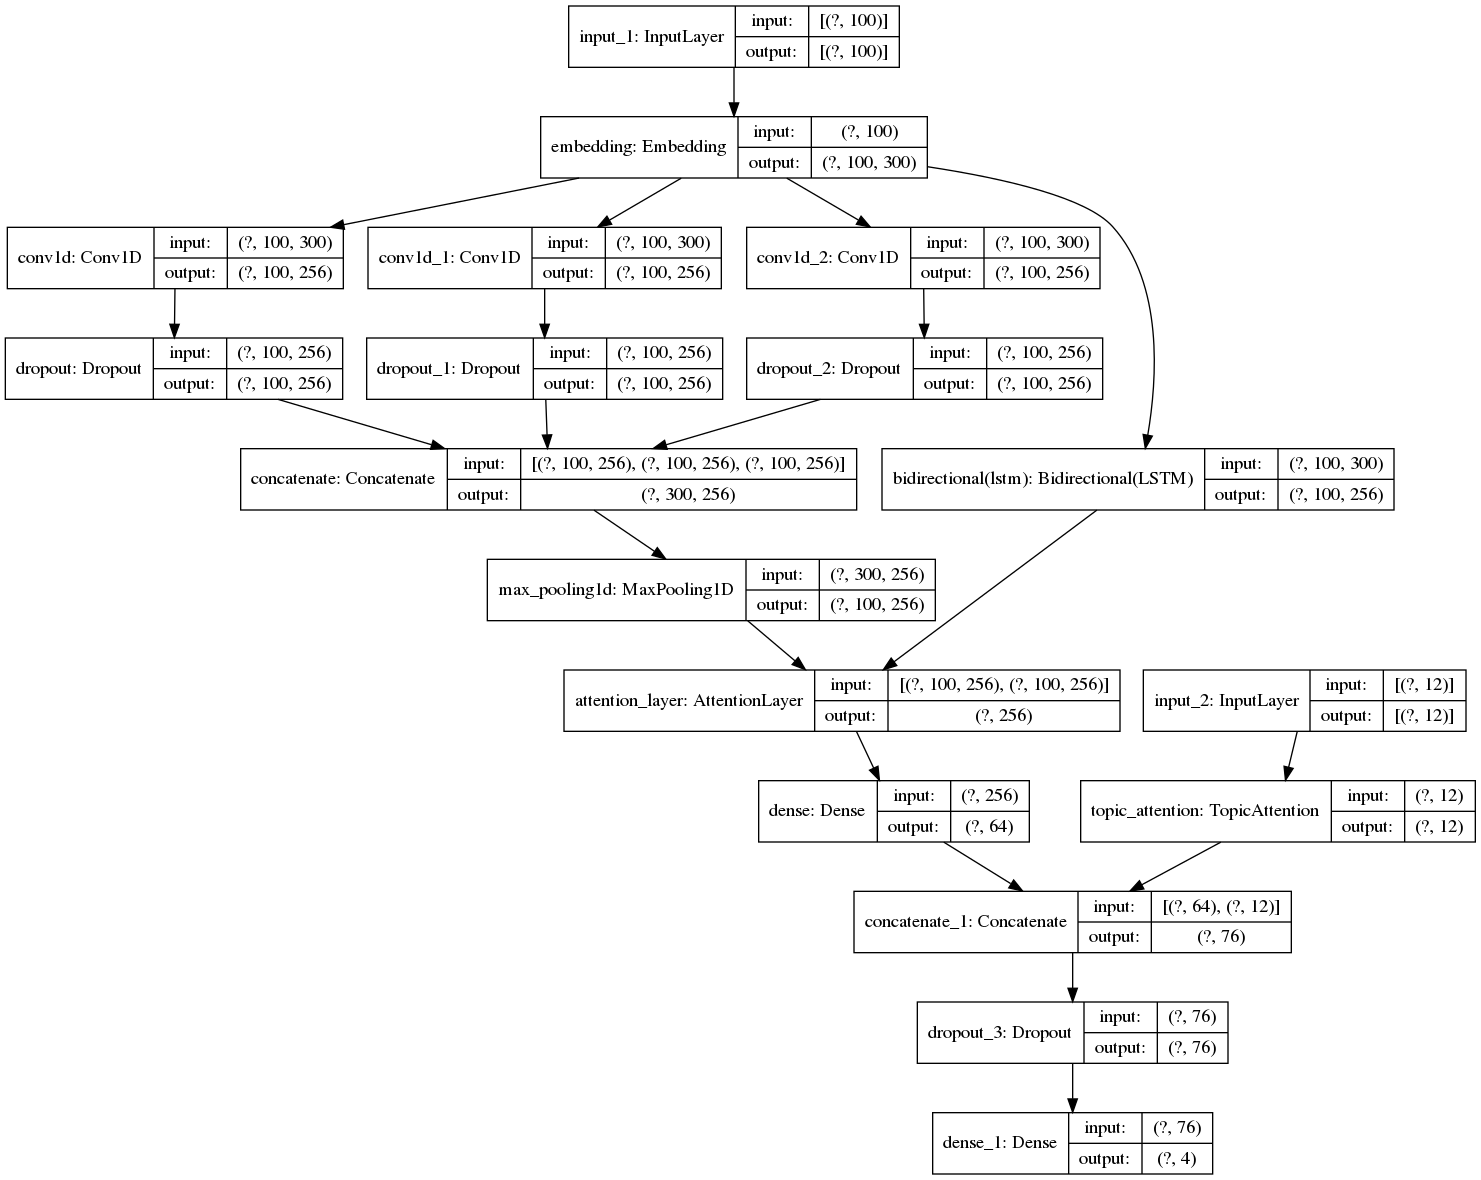

In [21]:
plot_model(classifier, show_shapes=True)

In [22]:
# ModelCheckPoint Callback:
checkpoint_filepath = "../models/embedding-LDA/multi-channel-embeddings-LDA-epoch-{epoch:02d}-val-acc-{val_acc:02f}.h5"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_acc',
                                            mode='max',
                                            save_freq = 'epoch',
                                            save_best_only=True)

# Reduce Learning Rate on Plateau Callback:
reduce_lr_callback = ReduceLROnPlateau( monitor='val_loss', 
                                       factor=0.1, 
                                       patience=2, 
                                       min_lr=0.0005, 
                                       verbose=2)
#myCB = myCallbacks(metrics='acc', threshold=0.97)

In [ ]:
history = classifier.fit([x_train_padded, X_train_LDA], 
                          y_train, 
                          epochs=20,
                          batch_size=128,
                          verbose=1,
                          validation_data=([x_val_padded, X_val_LDA], y_val),
                          callbacks=[model_checkpoint_callback, reduce_lr_callback])

Epoch 1/20
329/329 [==============================] - 428s 1s/step - loss: 0.5171 - acc: 0.8102 - val_loss: 0.3575 - val_acc: 0.8696 - lr: 0.0010
Epoch 2/20
329/329 [==============================] - 499s 2s/step - loss: 0.3822 - acc: 0.8624 - val_loss: 0.3633 - val_acc: 0.8698 - lr: 0.0010
Epoch 3/20
329/329 [==============================] - 438s 1s/step - loss: 0.3502 - acc: 0.8723 - val_loss: 0.3242 - val_acc: 0.8825 - lr: 0.0010
Epoch 4/20
193/329 [================>.............] - ETA: 2:51 - loss: 0.3228 - acc: 0.8842

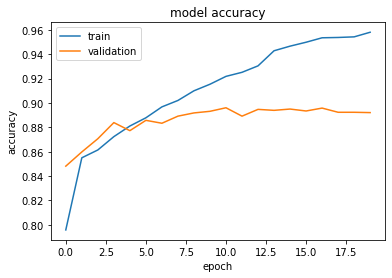

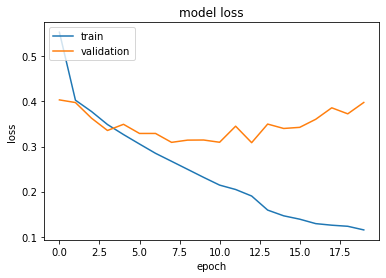

In [30]:
plot_curves(history)

In [32]:
#classifier.load_weights("multi-channel-embeddings-LDA-epoch-11-val-acc-0.896032.h5")

In [33]:
results = np.argmax(classifier.predict([x_val_padded, X_val_LDA]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8960317460317461

Precision:  [0.95820896 0.87935323 0.92191142 0.87946885]
Average Precision:  0.9097356141817822

Recall:  [0.76428571 0.93953488 0.89378531 0.88762887]
Average Recall:  0.8713086936801223

F1-Score:  [0.85033113 0.90844844 0.90763052 0.88353002]
Average F1-Score:  0.8874850263315058


In [31]:
results = np.argmax(classifier.predict([x_val_padded, X_val_LDA]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8920634920634921

Precision:  [0.9198895  0.8807571  0.91929825 0.87627812]
Average Precision:  0.8990557411944178

Recall:  [0.79285714 0.92757475 0.88813559 0.88350515]
Average Recall:  0.8730181603868054

F1-Score:  [0.8516624  0.90355987 0.90344828 0.8798768 ]
Average F1-Score:  0.8846368368047204


# Old 

In [28]:
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim1, 
                             output_dim=embedding_dim1, 
                             weights=[embedding_matrix1], 
                             trainable=False)(Input1)

# Input 1(BiLSTM):
Lstm = Bidirectional(LSTM(128, return_sequences=True))(Embedding_layer1)
max_pooling_lstm = GlobalMaxPooling1D()(Lstm)
Dropout_lstm = Dropout(0.3)(max_pooling_lstm)
Dense1 = Dense(64, activation='relu')(Dropout_lstm)
Dropout_dense = Dropout(0.25)(Dense1)

# Input 2(LDA):
Input2 = Input(shape=(input_len2, ))
attention = TopicAttention()(Input2)

merged = concatenate([Dropout_dense, attention])
outputs = Dense(4, activation='softmax')(merged)

classifier = Model(inputs=[Input1, Input2], outputs=outputs)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 300)     15772800    input_11[0][0]                   
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 100, 256)     439296      embedding_5[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_5 (GlobalM (None, 256)          0           bidirectional_5[0][0]            
______________________________________________________________________________________________

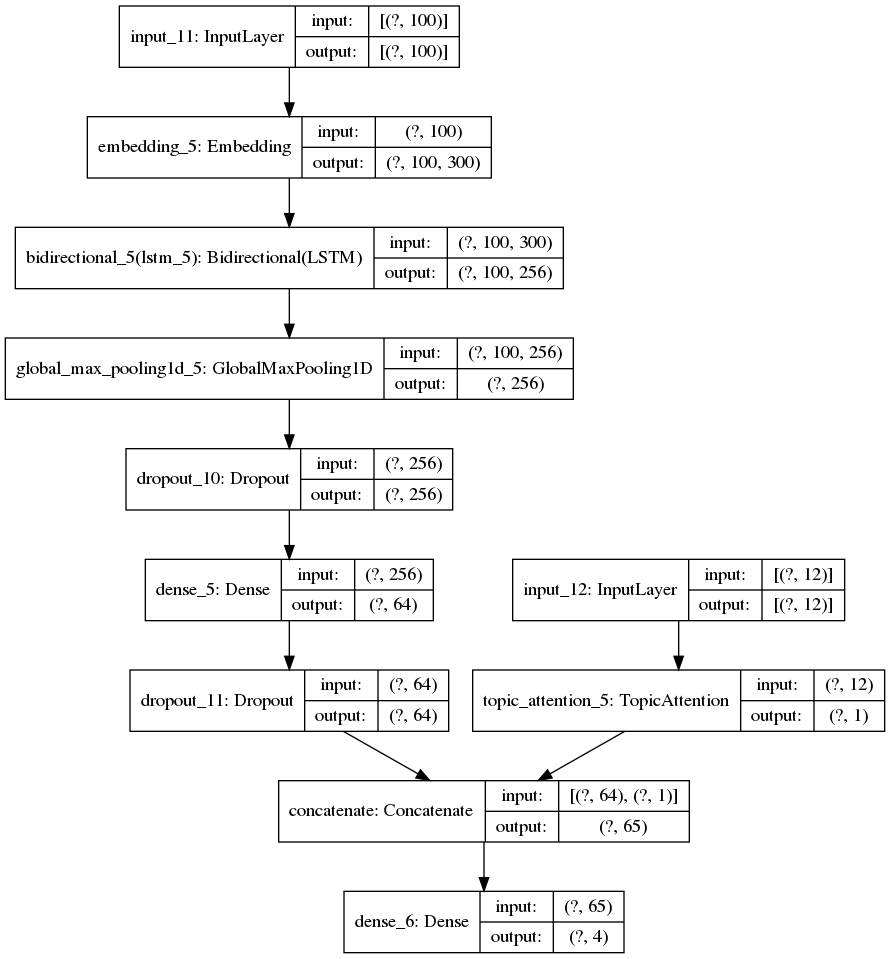

In [29]:
plot_model(classifier, show_shapes=True)

In [60]:
history2 = classifier.fit([x_train_padded, X_train_LDA], 
                          y_train, 
                          epochs=8,
                          batch_size=128,
                          verbose=1,
                          validation_data=([x_val_padded, X_val_LDA], y_val))

Epoch 1/8
329/329 [==============================] - 258s 785ms/step - loss: 0.5183 - acc: 0.8105 - val_loss: 0.3900 - val_acc: 0.8616
Epoch 2/8
329/329 [==============================] - 249s 758ms/step - loss: 0.3592 - acc: 0.8708 - val_loss: 0.3628 - val_acc: 0.8656
Epoch 3/8
329/329 [==============================] - 209s 636ms/step - loss: 0.3186 - acc: 0.8863 - val_loss: 0.3337 - val_acc: 0.8778
Epoch 4/8
329/329 [==============================] - 276s 838ms/step - loss: 0.2802 - acc: 0.8999 - val_loss: 0.3289 - val_acc: 0.8807
Epoch 5/8
329/329 [==============================] - 259s 787ms/step - loss: 0.2485 - acc: 0.9129 - val_loss: 0.3362 - val_acc: 0.8823
Epoch 6/8
329/329 [==============================] - 271s 825ms/step - loss: 0.2183 - acc: 0.9223 - val_loss: 0.3500 - val_acc: 0.8791
Epoch 7/8
329/329 [==============================] - 241s 732ms/step - loss: 0.1957 - acc: 0.9314 - val_loss: 0.3314 - val_acc: 0.8889
Epoch 8/8
329/329 [==============================] - 18

In [30]:
history = classifier.fit([x_train_padded, X_train_LDA], 
                          y_train, 
                          epochs=8,
                          batch_size=128,
                          verbose=1,
                          validation_data=([x_val_padded, X_val_LDA], y_val))

Epoch 1/8
329/329 [==============================] - 213s 649ms/step - loss: 0.5135 - acc: 0.8130 - val_loss: 0.3934 - val_acc: 0.8537
Epoch 2/8
329/329 [==============================] - 287s 871ms/step - loss: 0.3639 - acc: 0.8701 - val_loss: 0.3585 - val_acc: 0.8690
Epoch 3/8
329/329 [==============================] - 255s 774ms/step - loss: 0.3210 - acc: 0.8852 - val_loss: 0.3521 - val_acc: 0.8725
Epoch 4/8
329/329 [==============================] - 226s 687ms/step - loss: 0.2780 - acc: 0.9006 - val_loss: 0.3315 - val_acc: 0.8828
Epoch 5/8
329/329 [==============================] - 259s 787ms/step - loss: 0.2477 - acc: 0.9109 - val_loss: 0.3210 - val_acc: 0.8892
Epoch 6/8
329/329 [==============================] - 214s 651ms/step - loss: 0.2201 - acc: 0.9215 - val_loss: 0.3369 - val_acc: 0.8884
Epoch 7/8
329/329 [==============================] - 237s 722ms/step - loss: 0.1931 - acc: 0.9299 - val_loss: 0.3605 - val_acc: 0.8839
Epoch 8/8
329/329 [==============================] - 21

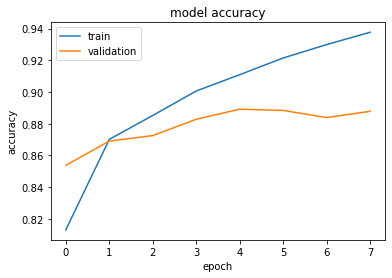

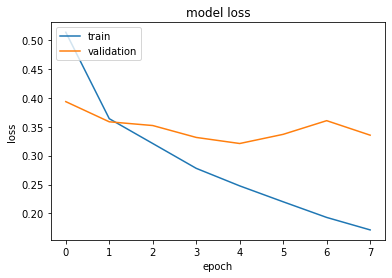

In [31]:
plot_curves(history)

In [32]:
results = np.argmax(classifier.predict([x_val_padded, X_val_LDA]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8878306878306879

Precision:  [0.89247312 0.88343949 0.93162393 0.85770363]
Average Precision:  0.8913100428400391

Recall:  [0.79047619 0.92159468 0.86214689 0.90103093]
Average Recall:  0.8688121738379978

F1-Score:  [0.83838384 0.90211382 0.89553991 0.87883358]
Average F1-Score:  0.8787177875853185


In [33]:
save_model(classifier, "multi-channel-BiLSTM-CNN/BiLSTM-LDA-Attention-f1-8787")

Confusion matrix, without normalization


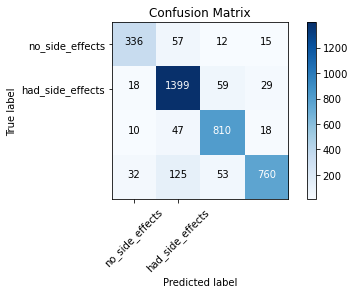

In [26]:
plot_confusion_matrix(y_val, 
                      results2, 
                      classes=['no_side_effects','had_side_effects'], 
                      title='Confusion Matrix',
                      normalize=False)